### 4. Now we want to build a model to truly graps the intearction between Cubee and the survival 
- We're assuming no direct link between Cubee and the survival but rather impact on the hive state and attribute leading to 
increase survival probability.

Therefore a BayesianNetwork suit well our problem since we have knowledge about the impact of cubee on the colonies attributes. We can do paramters learn on our data from a biologically relevant network. 

In [1]:
from pgmpy.models import DiscreteBayesianNetwork
from IPython.display import Image
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import TreeSearch
from pgmpy.sampling import BayesianModelSampling
from scipy.stats import gmean
import itertools
import networkx as nx
import math 
import pprint
import matplotlib.colors as mcolors

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

from cubee.configs.filepath import formatted_datapath, raw_datapath

from pgmpy.inference import VariableElimination
import time

INFO:numexpr.utils:NumExpr defaulting to 10 threads.


In [2]:
CUBEE_PERIOD = 3
data = pd.read_csv(formatted_datapath)
data.head()

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_cubee,queen_id,brood_pattern,stings,hid,hive_interacted
0,0,30,1,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0
1,30,59,1,39,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0
2,59,89,1,74,0,NaN,2.300327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0
3,89,118,1,98,0,6.61115,4.234924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1
4,118,148,1,125,1,6.00000,6.316360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1


In [3]:
data = pd.read_csv(formatted_datapath)
data['death'] = data["state"].apply(lambda x: True if x < 1 else False)
data['fob'] = data.groupby("hid")['fob'].ffill().pct_change(1).rolling(CUBEE_PERIOD).mean()
data['fobr'] = data.groupby("hid")['fobr'].ffill().pct_change(1).rolling(CUBEE_PERIOD).mean()
data['foh'] = data.groupby("hid")['foh'].ffill().pct_change(1).rolling(CUBEE_PERIOD).mean()
data['brood_pattern'] = data.groupby("hid")['brood_pattern'].ffill().pct_change(1).rolling(CUBEE_PERIOD).mean()
data['varroa'] = data.groupby("hid")['varroa'].ffill().pct_change(CUBEE_PERIOD).rolling(CUBEE_PERIOD).mean()
data['cubee'] = data.groupby("hid")['cubee'].rolling(CUBEE_PERIOD).sum().reset_index()['cubee'].shift(-1)
data['cubee'] = data['cubee'].fillna(0)
data.head(20)

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/2716656361.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['fob'] = data.groupby("hid")['fob'].ffill().pct_change(1).rolling(CUBEE_PERIOD).mean()
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/2716656361.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['fobr'] = data.groupby("hid")['fobr'].ffill().pct_change(1).rolling(CUBEE_PERIOD).mean()
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/2716656361.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated a

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_cubee,queen_id,brood_pattern,stings,hid,hive_interacted,death
0,0,30,1,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
1,30,59,1,39,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
2,59,89,1,74,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,0,False
3,89,118,1,98,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
4,118,148,1,125,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
5,148,178,1,150,2.0,NaN,4.375453e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,1,False
6,178,207,1,196,1.0,-3.081411e-02,1.469316e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,24,False
7,207,237,1,210,1.0,-3.700743e-17,-1.689942e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,23,False
8,0,30,1,278,0.0,7.401487e-17,-1.027706e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,23,False
9,30,60,1,306,0.0,7.401487e-17,7.401487e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46955,23,False


In [4]:
len(data)

2820

### Filter out low age colonies

In [5]:
cubee_model = DiscreteBayesianNetwork([ 
                                        ('Frames of bees', 'Varroa drop rate'),
                                        ('Reishi supplementation', 'Frames of brood'),
                                        ('Reishi supplementation', 'Frames of bees'),
                                        ('Reishi supplementation', 'Queen age'),
                                        ('Reishi supplementation', 'Colony mortality'), 
                                        ('Reishi supplementation', 'Frames of honey stored'),  
                                        ('Varroa drop rate', 'Colony mortality'),
                                        ('Frames of bees', 'Colony mortality'),
                                        ('Frames of brood', 'Colony mortality'),
                                        ('Queen age', 'Frames of brood'),
                                        ('Frames of brood', 'Varroa drop rate'),
                                        ('Hives interacted with','Varroa drop rate'),
                                        ('Hives interacted with','Frames of honey stored'),
                                        ('Queen age', 'Varroa drop rate'),
                                        ('Frames of brood','Frames of bees'),
                                        ('Queen age', 'Quality of brood'),
                                        ('Varroa drop rate', 'Quality of brood'),
                                        ('Queen age', 'Frames of honey stored'),
                                        ('Frames of bees', 'Frames of honey stored'),
                                         
                                      ])

In [6]:
label_mapper = {"cubee":"Reishi supplementation","fob":"Frames of bees","fobr":"Frames of brood","foh":"Frames of honey stored",
                "varroa":"Varroa drop rate","hive_interacted":"Hives interacted with","queen_age":"Queen age","death":"Colony mortality"
                ,"brood_pattern":"Quality of brood"}

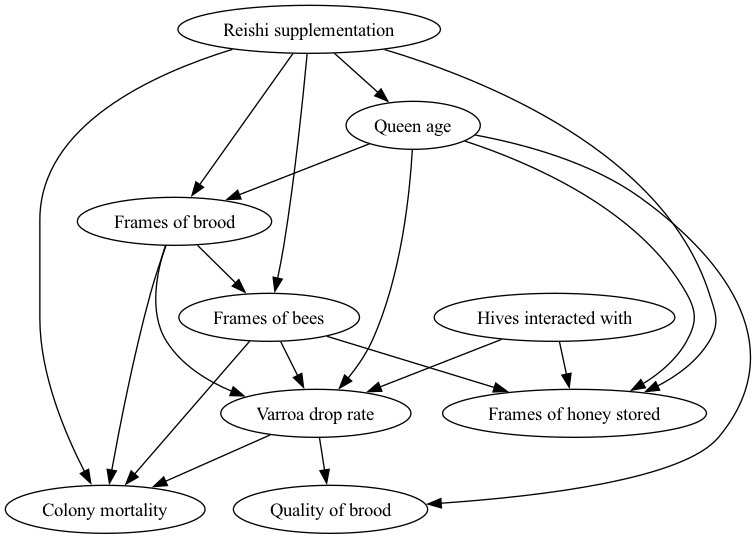

In [7]:
viz = cubee_model.to_graphviz()
viz.draw('cubee_model.png', prog='dot')
Image('cubee_model.png')

In [8]:
def growth(x):
    if x < 0.0:
        return 'decreased'
    elif x==0.0:
        return 'stable'
    elif x > 0.0:
        return 'increased'
    else:
        return None

In [9]:
def density(x):
    if x < 8:
        return 'low'
    elif (x >= 8) and (x <= 24):
        return 'medium'
    else:
        return 'high'

In [10]:
samples = data[['varroa', 'death', 'fob','foh','fobr','brood_pattern','hive_interacted', 'queen_age', 'hive_age', 'cubee']]
# samples['varroa'] = samples['varroa'].apply(lambda x: "over threshold" if x >= 3 else "healthy")
samples['varroa'] = samples['varroa'].apply(lambda x: growth(x))
samples['fob'] = samples['fob'].apply(lambda x: growth(x))
samples['fobr'] = samples['fobr'].apply(lambda x: growth(x))
samples['foh'] = samples['foh'].apply(lambda x: growth(x))
samples['brood_pattern'] = samples['brood_pattern'].apply(lambda x: growth(x))
# samples['brood_pattern'] = samples['brood_pattern'].fillna(0).astype(int).astype("category")
samples['hive_interacted'] = samples['hive_interacted'].apply(lambda x: density(x))
def t(x):
    try: 
        return math.floor(x/365) + 1
    except:
        return None
samples['queen_age'] = samples['queen_age'].apply(lambda x:  t(x))
samples['queen_age'] = samples['queen_age'].fillna(0)
samples['cubee'] = samples['cubee'].apply(lambda x: "cubeed" if x >0 else "control")
samples.tail(20)

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/1980674177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['varroa'] = samples['varroa'].apply(lambda x: growth(x))
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/1980674177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['fob'] = samples['fob'].apply(lambda x: growth(x))
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/1980674177.py:5: SettingWithCopyWarning: 
A value is trying to be set 

,varroa,death,fob,foh,fobr,brood_pattern,hive_interacted,queen_age,hive_age,cubee
2800,None,False,increased,increased,decreased,stable,high,1.0,15,control
2801,None,False,increased,increased,increased,stable,high,1.0,41,control
2802,None,True,increased,increased,increased,stable,high,1.0,62,control
2803,None,False,increased,increased,increased,decreased,high,1.0,15,control
2804,None,False,increased,increased,increased,stable,high,1.0,51,control
2805,None,False,increased,increased,increased,stable,high,1.0,81,control
2806,None,False,increased,increased,increased,increased,high,1.0,15,control
2807,None,False,increased,increased,increased,increased,high,1.0,42,control
2808,None,False,increased,increased,increased,increased,high,1.0,64,control
2809,increased,False,decreased,increased,decreased,decreased,low,0.0,0,control


In [11]:
samples = samples.rename(columns=label_mapper)
samples.head()

,Varroa drop rate,Colony mortality,Frames of bees,Frames of honey stored,Frames of brood,Quality of brood,Hives interacted with,Queen age,hive_age,Reishi supplementation
0,None,False,None,None,None,None,low,0.0,4,control
1,None,False,None,None,None,None,low,0.0,39,control
2,None,False,None,None,None,None,low,0.0,74,control
3,None,False,None,None,None,None,low,0.0,98,cubeed
4,None,False,None,None,None,None,low,0.0,125,cubeed


In [12]:

pe = ParameterEstimator(cubee_model, samples)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Varroa drop rate': 'C', 'Colony mortality': 'N', 'Frames of bees': 'C', 'Frames of honey stored': 'C', 'Frames of brood': 'C', 'Quality of brood': 'C', 'Hives interacted with': 'C', 'Queen age': 'N', 'hive_age': 'N', 'Reishi supplementation': 'C'}


In [13]:
print("\n", pe.state_counts('Reishi supplementation'))


                         count
Reishi supplementation       
control                  1841
cubeed                    979


In [14]:

# Access attributes of the model
nodes = cubee_model.nodes()
edges = cubee_model.edges()
cpds = cubee_model.get_cpds()

print(f"Nodes in the model: {nodes} \n")
print(f"Edges in the model: {edges} \n")
print(f"CPDs in the model: ")
print(cpds)

Nodes in the model: ['Frames of bees', 'Varroa drop rate', 'Reishi supplementation', 'Frames of brood', 'Queen age', 'Colony mortality', 'Frames of honey stored', 'Hives interacted with', 'Quality of brood'] 

Edges in the model: [('Frames of bees', 'Varroa drop rate'), ('Frames of bees', 'Colony mortality'), ('Frames of bees', 'Frames of honey stored'), ('Varroa drop rate', 'Colony mortality'), ('Varroa drop rate', 'Quality of brood'), ('Reishi supplementation', 'Frames of brood'), ('Reishi supplementation', 'Frames of bees'), ('Reishi supplementation', 'Queen age'), ('Reishi supplementation', 'Colony mortality'), ('Reishi supplementation', 'Frames of honey stored'), ('Frames of brood', 'Colony mortality'), ('Frames of brood', 'Varroa drop rate'), ('Frames of brood', 'Frames of bees'), ('Queen age', 'Frames of brood'), ('Queen age', 'Varroa drop rate'), ('Queen age', 'Quality of brood'), ('Queen age', 'Frames of honey stored'), ('Hives interacted with', 'Varroa drop rate'), ('Hives in

In [15]:

mle_est = MaximumLikelihoodEstimator(model=cubee_model, data=samples)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Varroa drop rate': 'C', 'Colony mortality': 'N', 'Frames of bees': 'C', 'Frames of honey stored': 'C', 'Frames of brood': 'C', 'Quality of brood': 'C', 'Hives interacted with': 'C', 'Queen age': 'N', 'hive_age': 'N', 'Reishi supplementation': 'C'}


In [16]:
print(mle_est.estimate_cpd(node="Reishi supplementation"))

+---------------------------------+----------+
| Reishi supplementation(control) | 0.652837 |
+---------------------------------+----------+
| Reishi supplementation(cubeed)  | 0.347163 |
+---------------------------------+----------+


In [17]:

# from IPython.core.display import display, HTML

# disable text wrapping in output cell
# display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

cubee_model.cpds = []
cubee_model.fit(data=samples, 
          estimator=BayesianEstimator,
          prior_type="BDeu",
               equivalent_sample_size=10)

print(f'Check model: {cubee_model.check_model()}\n')
for cpd in cubee_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Varroa drop rate': 'C', 'Colony mortality': 'N', 'Frames of bees': 'C', 'Frames of honey stored': 'C', 'Frames of brood': 'C', 'Quality of brood': 'C', 'Hives interacted with': 'C', 'Queen age': 'N', 'hive_age': 'N', 'Reishi supplementation': 'C'}


Check model: True

CPT of Frames of bees:
+---------------------------+-----+--------------------------------+
| Frames of brood           | ... | Frames of brood(stable)        |
+---------------------------+-----+--------------------------------+
| Reishi supplementation    | ... | Reishi supplementation(cubeed) |
+---------------------------+-----+--------------------------------+
| Frames of bees(decreased) | ... | 0.5833333333333333             |
+---------------------------+-----+--------------------------------+
| Frames of bees(increased) | ... | 0.3267543859649123             |
+---------------------------+-----+--------------------------------+
| Frames of bees(stable)    | ... | 0.08991228070175437            |
+---------------------------+-----+--------------------------------+ 

CPT of Varroa drop rate:
+-----------------------------+-----+-------------------------------+
| Frames of bees              | ... | Frames of bees(stable)        |
+-----------------------------+-

In [18]:
# print(f'There can be made {len(cubee_model.get_independencies().get_assertions())}',
#       'valid independence assertions with respect to the all possible given evidence.')
# print('For instance, any node in the network is independent of its non-descendents given its parents (local semantics):\n',
#       f'\n{model.local_independencies(nodes)}\n')

def active_trails_of(query, evidence):
    active = cubee_model.active_trail_nodes(query, observed=evidence).get(query)
    active.remove(query)
    if active:
        if evidence:
            print(f'Active trails between \'{query}\' and {active} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {active} given no evidence.')
    else:
        print(f'No active trails for \'{query}\' given the evidence {set(evidence)}.')
        
def markov_blanket_of(node):
    print(f'Markov blanket of \'{node}\' is {set(cubee_model.get_markov_blanket(node))}')

active_trails_of(query='Colony mortality', evidence=[])
active_trails_of(query='Colony mortality', evidence=['Reishi supplementation'])
active_trails_of(query='Colony mortality', evidence=['Reishi supplementation', 'Varroa drop rate'])
active_trails_of(query='Colony mortality', evidence=['Reishi supplementation','Frames of bees','Varroa drop rate'])
active_trails_of(query='Varroa drop rate', evidence=['Reishi supplementation', 'Frames of bees'])
print()
markov_blanket_of(node='Frames of bees')
markov_blanket_of(node='Varroa drop rate')
markov_blanket_of(node='Colony mortality')
markov_blanket_of(node='Reishi supplementation') 

Active trails between 'Colony mortality' and {'Frames of honey stored', 'Frames of bees', 'Frames of brood', 'Varroa drop rate', 'Hives interacted with', 'Quality of brood', 'Queen age', 'Reishi supplementation'} given no evidence.
Active trails between 'Colony mortality' and {'Frames of honey stored', 'Frames of bees', 'Frames of brood', 'Varroa drop rate', 'Hives interacted with', 'Quality of brood', 'Queen age'} given the evidence {'Reishi supplementation'}.
Active trails between 'Colony mortality' and {'Hives interacted with', 'Queen age', 'Frames of honey stored', 'Frames of bees', 'Quality of brood', 'Frames of brood'} given the evidence {'Varroa drop rate', 'Reishi supplementation'}.
Active trails between 'Colony mortality' and {'Hives interacted with', 'Queen age', 'Frames of honey stored', 'Quality of brood', 'Frames of brood'} given the evidence {'Varroa drop rate', 'Frames of bees', 'Reishi supplementation'}.
Active trails between 'Varroa drop rate' and {'Colony mortality', 

In [19]:


def query_report(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    if desc:
        print(desc)
    start_time = time.time()
    print(infer.query(variables=variables, 
                      evidence=evidence, 
                      elimination_order=elimination_order, 
                      show_progress=show_progress))
    print(f'--- Query executed in {time.time() - start_time:0,.4f} seconds ---\n')
    
def get_ordering(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    start_time = time.time()
    ordering = infer._get_elimination_order(variables=variables, 
                                        evidence=evidence, 
                                        elimination_order=elimination_order, 
                                        show_progress=show_progress)
    if desc:
        print(desc, ordering, sep='\n')
        print(f'--- Ordering found in {time.time() - start_time:0,.4f} seconds ---\n')
    return ordering

def padding(heuristic):
    return (heuristic + ":").ljust(16)

def compare_all_ordering(infer, variables, evidence=None, show_progress=False):
    ord_dict = {
        "MinFill": get_ordering(infer, variables, evidence, "MinFill", show_progress),
        "MinNeighbors": get_ordering(infer, variables, evidence, "MinNeighbors", show_progress),
        "MinWeight": get_ordering(infer, variables, evidence, "MinWeight", show_progress),
        "WeightedMinFill": get_ordering(infer, variables, evidence, "WeightedMinFill", show_progress)
    }
    if not evidence:
        pre = f'elimination order found for probability query of {variables} with no evidence:'
    else:
        pre = f'elimination order found for probability query of {variables} with evidence {evidence}:'
    if ord_dict["MinFill"] == ord_dict["MinNeighbors"] and ord_dict["MinFill"] == ord_dict["MinWeight"] and ord_dict["MinFill"] == ord_dict["WeightedMinFill"]:
        print(f'All heuristics find the same {pre}.\n{ord_dict["MinFill"]}\n')
    else:
        print(f'Different {pre}')
        for heuristic, order in ord_dict.items():
            print(f'{padding(heuristic)} {order}')
        print()
            
infer = VariableElimination(cubee_model)

var = ['Colony mortality']
heuristic = "MinNeighbors"
ordering = get_ordering(infer, variables=var, elimination_order=heuristic,
                        desc=f'Elimination order for {var} with no evidence computed through {heuristic} heuristic:')
query_report(infer, variables=var, elimination_order=ordering, 
             desc=f'Probability query of {var} with no evidence through precomputed elimination order:') 
query_report(infer, variables=var, elimination_order=list(reversed(ordering)), 
             desc=f'Probability query of {var} with no evidence through dummy elimination order:')
compare_all_ordering(infer, variables=var)

var = ['Colony mortality']
ev = {'Reishi supplementation': "cubeed", "Frames of bees":"increased",'Varroa drop rate':'increased'}
heuristic = "MinNeighbors"
query_report(infer, variables=var, evidence=ev, elimination_order=heuristic, 
             desc=f'Probability query of {var} with evidence {ev} computed through {heuristic} heuristic:')
compare_all_ordering(infer, variables=var, evidence=ev)



Elimination order for ['Colony mortality'] with no evidence computed through MinNeighbors heuristic:
['Quality of brood', 'Frames of honey stored', 'Hives interacted with', 'Queen age', 'Frames of bees', 'Frames of brood', 'Varroa drop rate', 'Reishi supplementation']
--- Ordering found in 0.0015 seconds ---

Probability query of ['Colony mortality'] with no evidence through precomputed elimination order:
+-------------------------+-------------------------+
| Colony mortality        |   phi(Colony mortality) |
+=========================+=========================+
| Colony mortality(False) |                  0.9320 |
+-------------------------+-------------------------+
| Colony mortality(True)  |                  0.0680 |
+-------------------------+-------------------------+
--- Query executed in 0.0047 seconds ---

Probability query of ['Colony mortality'] with no evidence through dummy elimination order:
+-------------------------+-------------------------+
| Colony mortality       

In [20]:
varroa_cpd = cubee_model.get_cpds()[2]
cpds = varroa_cpd.to_dataframe().reset_index()
# cpds['fob'] = pd.Categorical(cpds['fob'], ["weak","medium","strong"])
cpds['Varroa drop rate'] = pd.Categorical(cpds['Varroa drop rate'], ["decreased","stable","increased"])
cpds = cpds.groupby(["Reishi supplementation","Varroa drop rate","Frames of bees"]).mean(numeric_only=True)
cpds = cpds.drop(False,axis=1)
cpds = cpds.rename(columns={True:"Mortality Rate"})

cpds = cpds.sort_values(["Reishi supplementation","Varroa drop rate","Frames of bees"])
cpds = cpds.groupby(["Reishi supplementation","Varroa drop rate","Frames of bees"]).mean()
cpds['Mortality Rate'] = cpds['Mortality Rate'].apply(lambda x: int(x*100))


/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/3214963057.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cpds = cpds.groupby(["Reishi supplementation","Varroa drop rate","Frames of bees"]).mean(numeric_only=True)
/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/3214963057.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cpds = cpds.groupby(["Reishi supplementation","Varroa drop rate","Frames of bees"]).mean()


In [21]:
from pandas.plotting import table

In [22]:
cpds.reset_index(inplace=True)
cpds.style.background_gradient(cmap="YlGnBu", vmin=0, vmax=100).set_properties(**{'text-align': 'center'})


Colony mortality,Reishi supplementation,Varroa drop rate,Frames of bees,Mortality Rate
0,control,decreased,decreased,17
1,control,decreased,increased,4
2,control,decreased,stable,21
3,control,stable,decreased,9
4,control,stable,increased,8
5,control,stable,stable,7
6,control,increased,decreased,23
7,control,increased,increased,11
8,control,increased,stable,25
9,cubeed,decreased,decreased,2


In [23]:
cpds.groupby(["Varroa drop rate","Reishi supplementation"]).mean(numeric_only=True)

/var/folders/w6/lsz40xfn239dhtzy05m2r2jw0000gn/T/ipykernel_2146/3048877198.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cpds.groupby(["Varroa drop rate","Reishi supplementation"]).mean(numeric_only=True)


Colony mortality                         Mortality Rate
Varroa drop rate Reishi supplementation                
decreased        control                      14.000000
                 cubeed                       11.333333
stable           control                       8.000000
                 cubeed                        5.666667
increased        control                      19.666667
                 cubeed                        7.333333

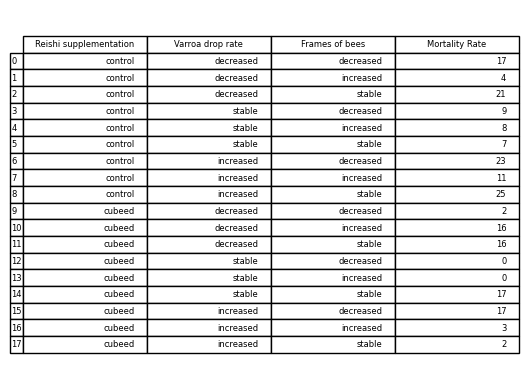

In [24]:
ax = plt.subplot(111, frame_on=False)  # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
table(ax, cpds, loc="center")  # where df is your data frame
plt.savefig("mytable.png")

### Making a heat map viz for the CPD table here

In [25]:
import numpy as np
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork

def calculate_mi(model, u, v):
    """
    Calculates the mutual information between two nodes (u and v) in a pgmpy BayesianNetwork.
    Assumes a directed edge exists from u to v.

    Args:
        model (pgmpy.models.BayesianNetwork): The Bayesian network model.
        u (str): Name of the parent node.
        v (str): Name of the child node.

    Returns:
        float: The mutual information value in bits (using log base 2).
    """
    if (u, v) not in model.edges() and (v, u) not in model.edges():
        return 0.0 # No direct edge, MI is not the relevant metric here.

    # Initialize the inference method
    # This might take some time for large, complex networks
    inference = VariableElimination(model)

    # 1. Get the joint probability distribution P(u, v)
    # The result is a Belief Propagation object that can be converted to a pandas DataFrame/Series
    jpd_query = inference.query(variables=[u, v], joint=True)
    jpd_values = jpd_query.values.flatten()
    
    # 2. Get the marginal probability distribution P(u)
    p_u_query = inference.query(variables=[u])
    p_u_values = p_u_query.values.flatten()

    # 3. Get the marginal probability distribution P(v)
    p_v_query = inference.query(variables=[v])
    p_v_values = p_v_query.values.flatten()

    # Get cardinatlities to reshape marginals
    card_u = model.get_cardinality(u)
    card_v = model.get_cardinality(v)

    # Reshape marginals for element-wise operation: P(u) * P(v)
    p_u_matrix = p_u_values.reshape(-1, 1) # Column vector for u states
    p_v_matrix = p_v_values.reshape(1, -1) # Row vector for v states
    p_uv_indep = np.dot(p_u_matrix, p_v_matrix).flatten() # P(u)*P(v) as a flat array
    
    # Reshape the JPD into a 2D matrix for clarity, then flatten
    jpd_values_matrix = jpd_query.values.reshape(card_u, card_v)
    jpd_values = jpd_values_matrix.flatten()

    # 4. Calculate Mutual Information using the formula:
    # I(U; V) = sum( P(u, v) * log2( P(u, v) / (P(u) * P(v)) ) )
    
    # Avoid log(0) and division by zero issues by adding a small epsilon
    epsilon = 1e-12
    ratio = (jpd_values + epsilon) / (p_uv_indep + epsilon)
    
    # The core MI calculation
    mi_values = jpd_values * np.log2(ratio)
    mutual_info = np.sum(mi_values)
    
    # MI is symmetric, I(U; V) == I(V; U), and always non-negative
    return max(0.0, mutual_info)



In [26]:
agraph = cubee_model.to_graphviz()
weights = {}

for u, v in cubee_model.edges():
    weight = calculate_mi(cubee_model, u, v)
    weights[(u, v)] = weight

max_weight = max(list(weights.values())) if max(list(weights.values())) > 0 else 1

for u, v in cubee_model.edges():
    weight = weights[(u, v)]
    # Use weight to set visual properties
    penwidth = (weight / max_weight) * 5 + 1 
    color = "gray"
    label = f"MI: {weight:.3f}"

    edge = agraph.get_edge(u, v)
    edge.attr['label'] = label
    edge.attr['color'] = color
    edge.attr['penwidth'] = str(penwidth) 

agraph.draw("mutual_information_cubee_model.png", prog="dot")